# **Customer Segmentation Notebook Showing Modeling Using KMeans Clustering**

### In this notebook we will establish a baseline foundation for our customers, scaling our data as well as using PCA to reduce dimensionality.  We will also create custom features and use several Clustering models to extract unique clusters of customer groups based on the features input to the model.  We will then observe the characteristics of each cluster and give each identities that we will use in the rest of our project.

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist


#### Let's begin again by bringing in our main dataframe and taking a quick look.

In [4]:
df_mod = pd.read_csv(f'/Users/ryanm/Desktop/df-mod.csv')
df_mod = df_mod.drop(columns = ['product_name', 'aisle', 'department'])
print(df_mod.shape)
df_mod.head(5)

(3214874, 13)


,user_id,order_number,order_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id,avg_orders,order_dow_name
0,1,1,2539329,3,9,12.0,26405,5,0,54,17,23488,Wednesday
1,1,2,2398795,4,8,16.0,26088,6,1,23,19,11739,Thursday
2,1,3,473747,4,13,22.0,30450,5,1,88,13,31580,Thursday
3,1,4,2254736,5,8,30.0,26405,5,1,54,17,11823,Friday
4,1,5,431534,5,16,29.0,41787,8,1,24,4,32095,Friday


#### Before we start our first baseline model in our KMeans let's scale the dataframe features we need so our data is normalized.  This will help our output and the definition of our clusters that we want to extract from our data.

In [5]:
time_between_purchases = df_mod.groupby('user_id')['days_since_prior_order'].mean().reset_index()
time_between_purchases = time_between_purchases.rename(columns = {'days_since_prior_order' : 'time_between_purchases'})
time_between_purchases['purchase_frequency'] = 1 / time_between_purchases['time_between_purchases']

user_behavior = df_mod.groupby('user_id').agg({
    'order_dow' : 'mean',
    'order_hour_of_day' : 'mean'
    }).rename(columns={'order_dow' : 'order_dow_mean', 'order_hour_of_day' : 'order_hour_of_day_mean'}).reset_index()

user_behavior = user_behavior.merge(time_between_purchases, on = 'user_id')

user_ids = user_behavior['user_id']

user_behavior_feats = user_behavior.drop(columns =['user_id'])

print(user_behavior.head())

scaler = StandardScaler()

df_user_scaled = scaler.fit_transform(user_behavior_feats)
df_user_scaled = pd.DataFrame(df_user_scaled, index = user_behavior_feats.index, columns = user_behavior_feats.columns)

kmeans_scaled = df_user_scaled
print(kmeans_scaled.head())

   user_id  order_dow_mean  order_hour_of_day_mean  time_between_purchases  \
0        1        3.500000               11.300000               19.700000   
1        2        3.142857               11.571429               15.928571   
2        3        2.083333               17.416667               13.000000   
3        4        5.800000               13.600000               14.200000   
4        5        2.750000               17.000000               13.750000   

   purchase_frequency  
0            0.050761  
1            0.062780  
2            0.076923  
3            0.070423  
4            0.072727  
   order_dow_mean  order_hour_of_day_mean  time_between_purchases  \
0       -0.269018               -1.557111                0.764202   
1       -0.648385               -1.428500                0.110680   
2       -1.773842                1.341157               -0.396789   
3        2.174108               -0.467299               -0.188850   
4       -1.065689                1.143728 

#### Here we created a couple features that will help us classify our intended clusters of users/customers.  What we are looking for in our customer groups are relationships based on:
#### -Their purchase frequency
#### -Avg time between purchases
#### -Avg time of day of user purchases
#### -Avg day of user purchases

#### In examining these features I look to extract n clusters from our data based on these features we have created.

#### Now let's apply PCA to reduce the dimensionality of our data, making it easier for us to visualize and interpret.  This will also allow our forthcoming models more efficient to process.

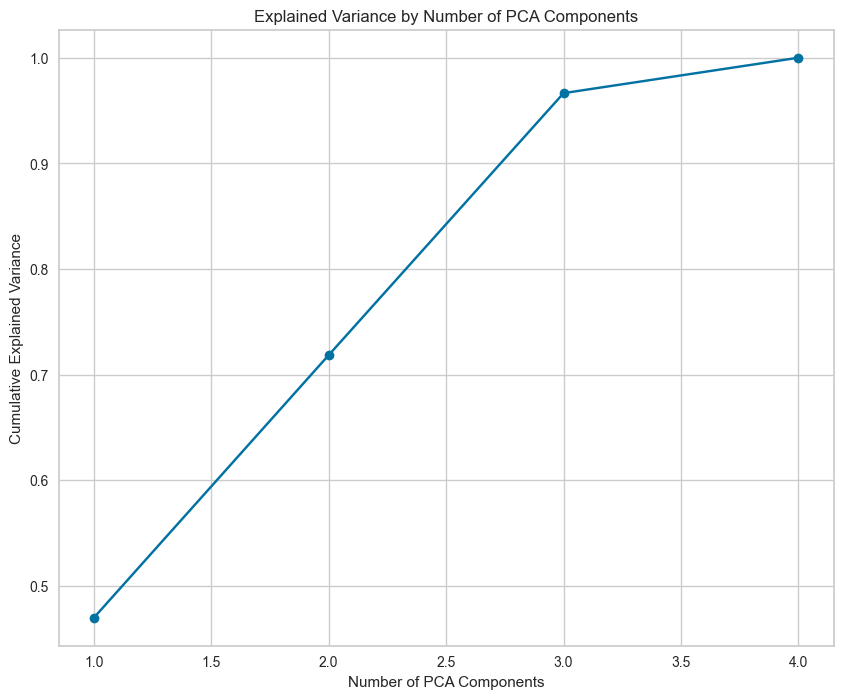

In [6]:
pca = PCA().fit(df_user_scaled)
plt.figure(figsize = (10,8))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker = 'o')
plt.title('Explained Variance by Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

#### So when choosing n_components we have to decide how many of the components we want to keep vs how much of the variance we want.  It is a tradeoff of sorts.  You are looking at improving model performance at the cost of complexity.  So in this case you aren't just picking the 'best' (read n_components = 4) here.  You want to strike a balance that suits your needs.  Here I am looking to choose n_components = 2.  While I might lose out on some of the more complex relationships I could attain with n_components = 3, I gain on the efficiency of my modeling and the ease of use of my plotting.  Noise is reduced as well.  Overall it is a benefit that works for this project.

#### Let's fit the components to our dataframe so we can use it for the remainder of our analysis.

In [7]:
n_components = 2
pca_fit = PCA(n_components=n_components)
pca_features = pca_fit.fit_transform(kmeans_scaled)

#### Great, now let's see how the newly-scaled features and component data look in a KMeans model, so we can see what clusters we can begin to extract for our customer data.

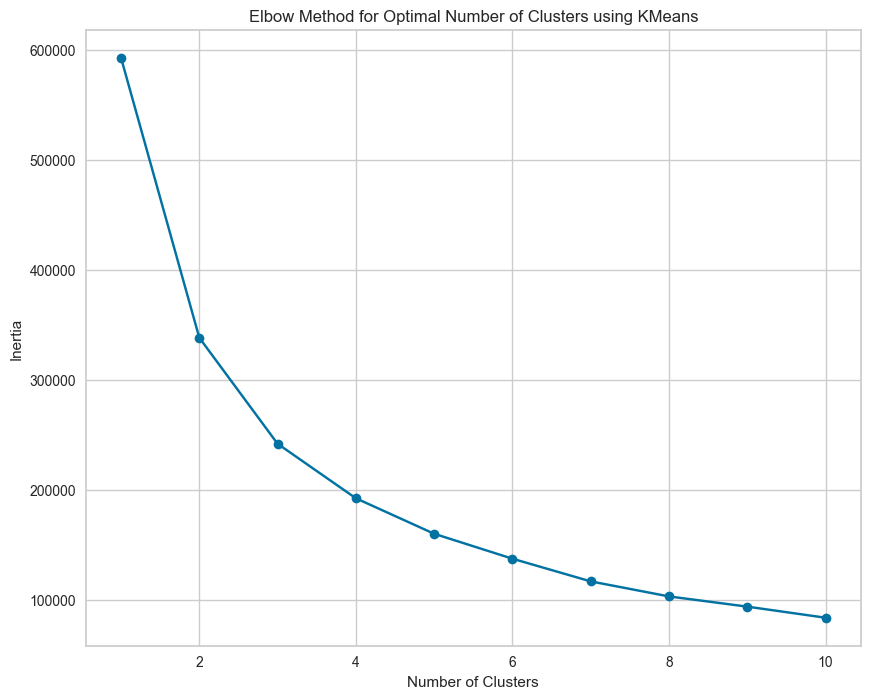

In [8]:
cust_list = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_features)
    cust_list.append(kmeans.inertia_)

plt.figure(figsize = (10,8))
plt.plot(range(1,11), cust_list, marker = 'o')
plt.title('Elbow Method for Optimal Number of Clusters using KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

#### Looks like at least from this elbow plot like the best k value is k=4 due to how the plot starts to 'flatten' or more specifically where the Inertia decreases more slowly at that point.  I will still observe a silhouette plot for this data just to confirm this k value so we can revise our Clustering models and more efficiently extract our customer clusters.

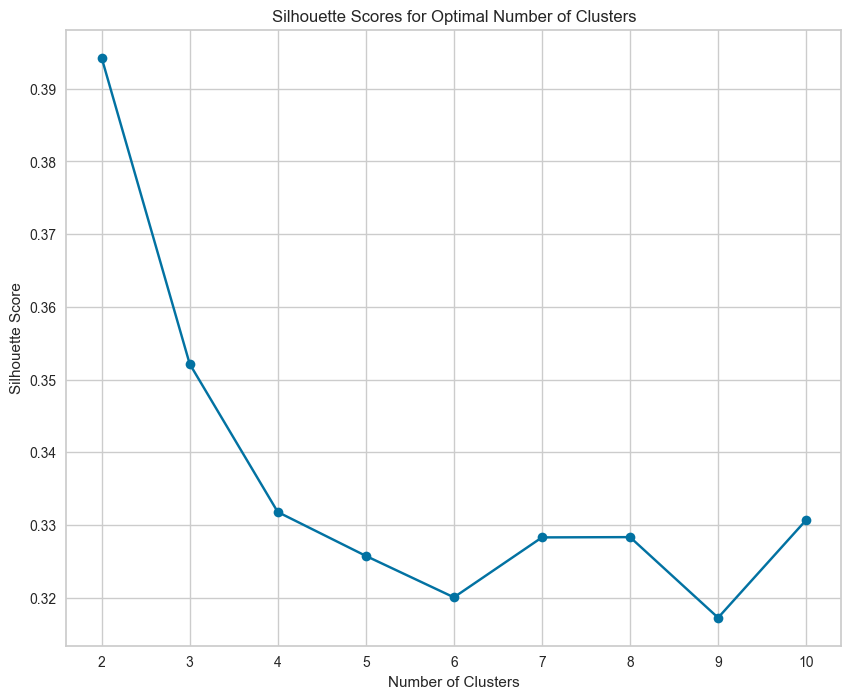

In [9]:
silhouette_scores = []

for i in range(2,11):
    kmeans = KMeans(n_clusters= i, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_features)
    silhouette_avg = silhouette_score(pca_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize = (10,8))
plt.plot(range(2,11), silhouette_scores, marker = 'o')
plt.title('Silhouette Scores for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()





#### Now that the scores have been obtained, let's plot each cluster to view them as well using the yellowbrick library and a silhouette analysis.  I will reduce the range needed to a max of 7, as I feel confident in our initial k=4 value to start.

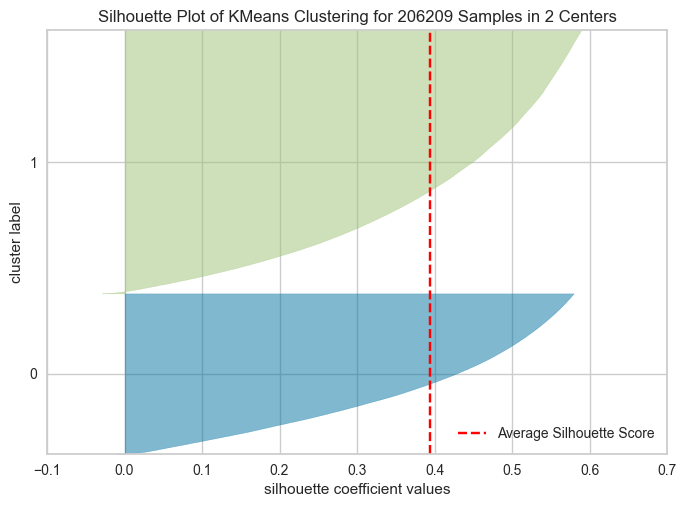

Silhouette score for n_clusters = 2: 0.39425226643179045


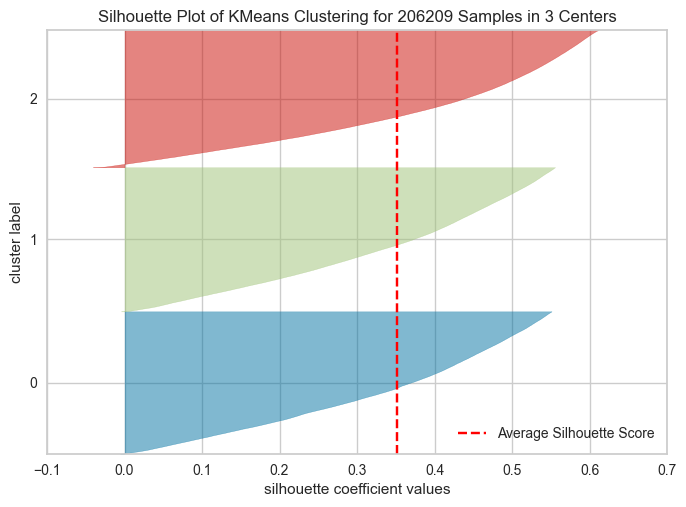

Silhouette score for n_clusters = 3: 0.35214482246810624


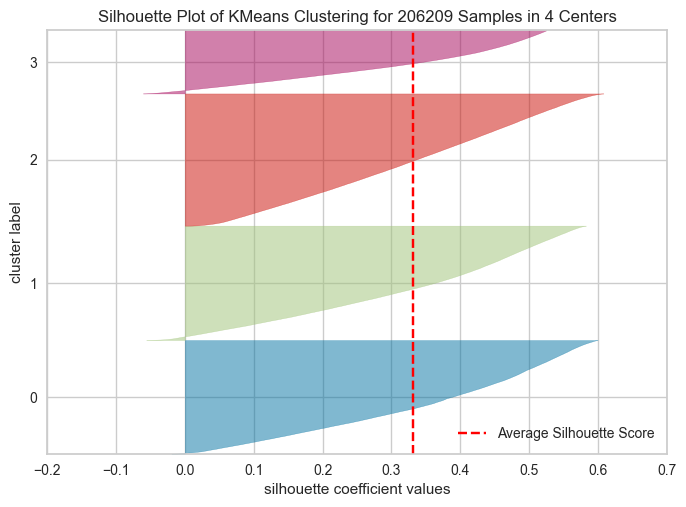

Silhouette score for n_clusters = 4: 0.3317834438314493


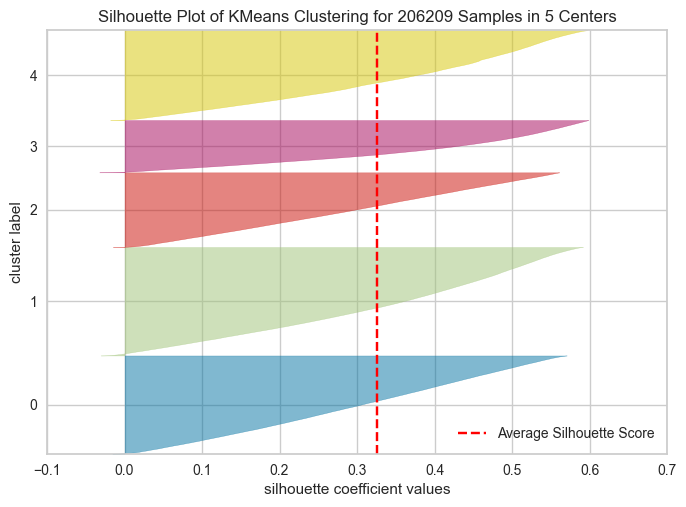

Silhouette score for n_clusters = 5: 0.32574910792516987


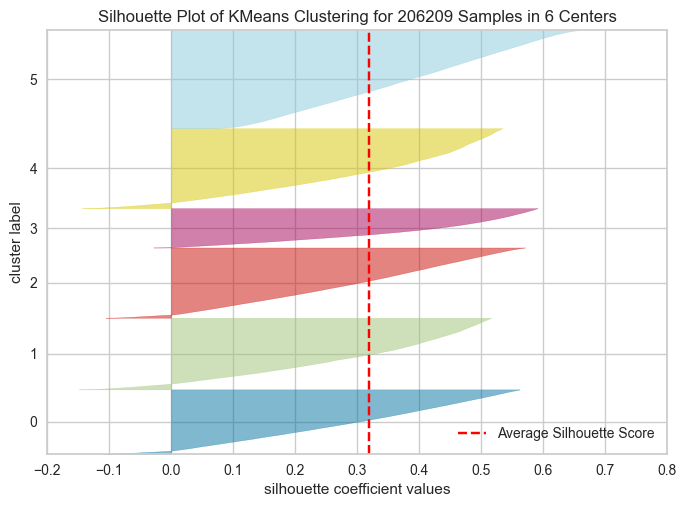

Silhouette score for n_clusters = 6: 0.32004923778227784


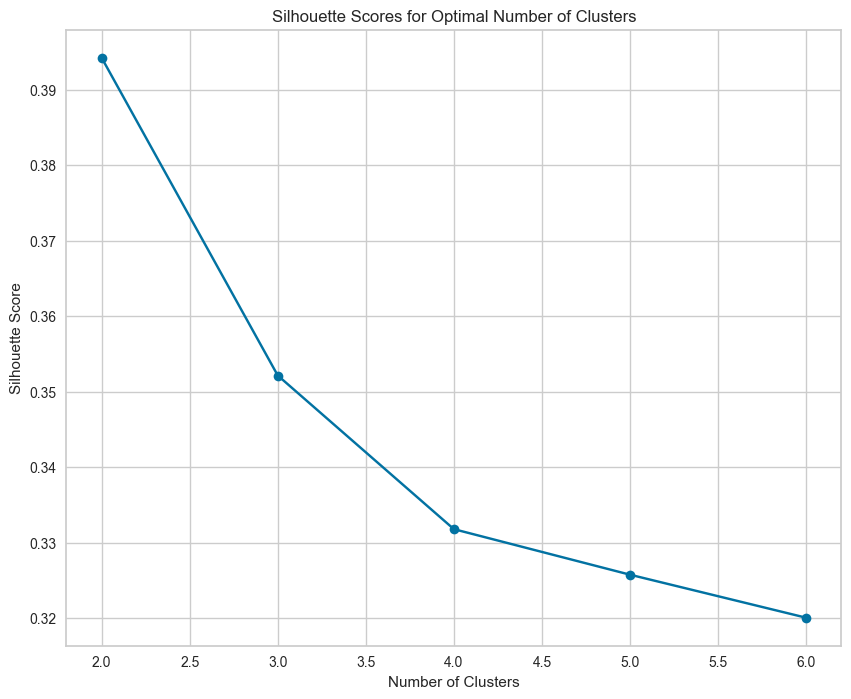

In [10]:
silhouette_scores = []

for n_clusters in range(2,7):
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
    visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick')
    visualizer.fit(pca_features)
    visualizer.show()

    cluster_labels = kmeans.predict(pca_features)
    silhouette_avg = silhouette_score(pca_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Silhouette score for n_clusters = {n_clusters}: {silhouette_avg}")

plt.figure(figsize = (10,8))
plt.plot(range(2,7), silhouette_scores, marker = 'o')
plt.title('Silhouette Scores for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


#### In observing our silhouette plots the results actually differ a bit from our previous plots.  The silhouette analysis shows our best k value to be k = 3.  Even though k = 4 is still a solid k value with a good silhouette score, k = 3 has a better score and noticeably less overlap in the clusters.  Also the size of each cluster (the width) is more consistent than with k = 4.  Going back to the previous plots too an argument can be made for k = 3 as a choice k value.  

#### Let's also observe a pairplot using our new optimal k value to see some potential relationships within these clusters.

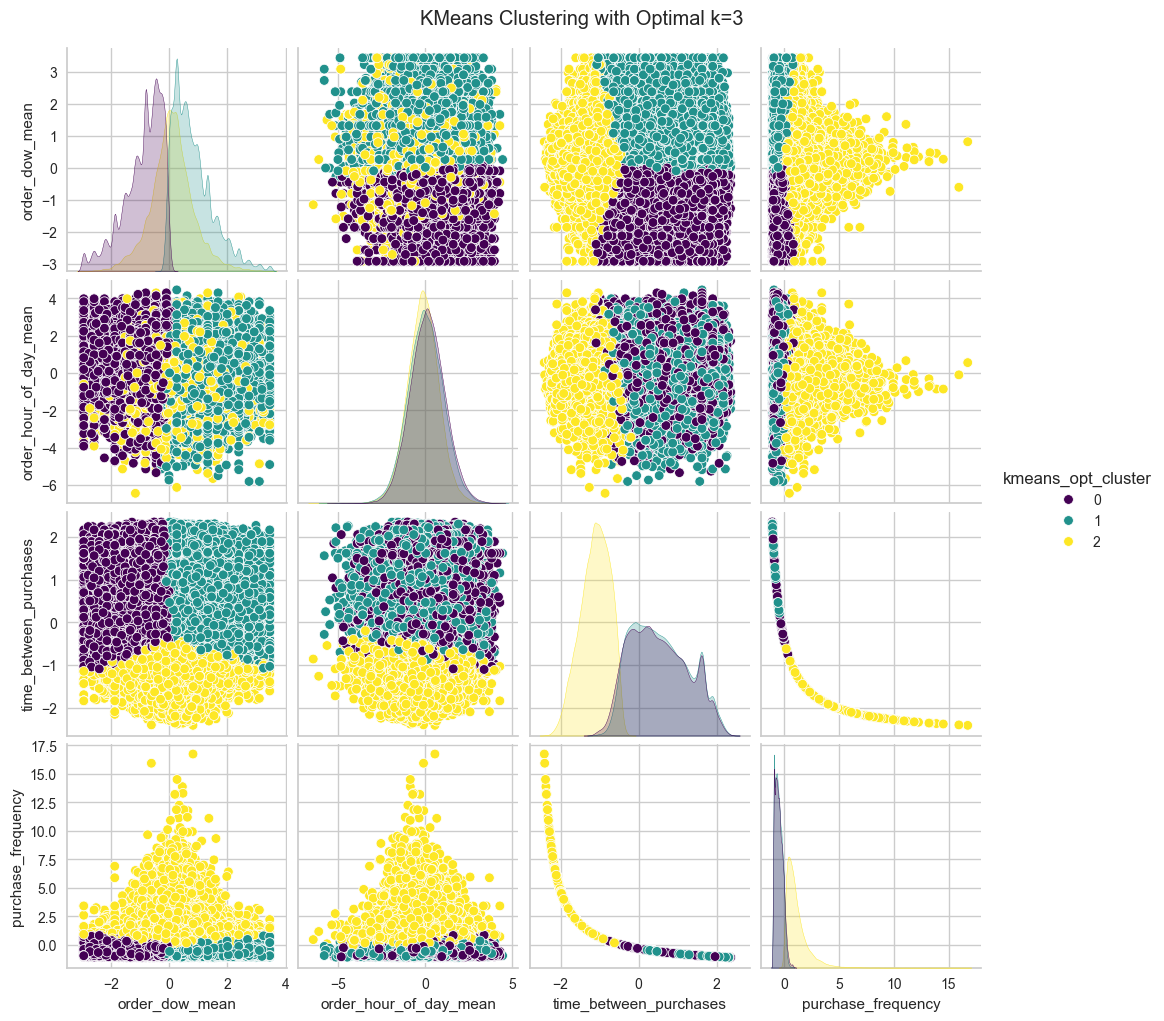

In [11]:
optimal_k = 3

kmeans = KMeans(n_clusters = optimal_k, random_state = 42)
df_user_scaled['kmeans_opt_cluster'] = kmeans.fit_predict(pca_features)

sns.pairplot(kmeans_scaled, hue = 'kmeans_opt_cluster', palette = 'viridis', diag_kind = 'kde')
plt.suptitle(f'KMeans Clustering with Optimal k={optimal_k}', y = 1.02)
plt.show()

#### Some clear and distinct observations can be made here based on the above pairplot.  When looking at the subplots identified between time_between_purchases and purchase_frequency, Cluster 2 (yellow) shows the least time between purchases as well as having the highest purchase frequency.  This would indicate that this user cluster would be our frequent or loyal customer base.  You can also see in the order_dow_mean vs time_between_purchases there is also noticeable separation in the clusters, with some observations being that Cluster 0 only purchases in the first half of the week while Cluster 1 seems to, on average, purchase during the second half of the week with both of the aforementioned Clusters having relatively the same amount of time in between purchases.    

#### Looking above at the pairplots, you can see outliers in our data.  Let's identify and set them to the side for now(in this case as they could be valuable since we are examining clusters of customer behavior); in doing so they will help the core of our customer clusters become more efficient.

In [14]:
kmeans_scaled['outliers'] = False

for cluster in range(1,11):
    cluster_data = kmeans_scaled[kmeans_scaled['kmeans_opt_cluster'] == cluster]
    Q1 = cluster_data['purchase_frequency'].quantile(0.25)
    Q3 = cluster_data['purchase_frequency'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = cluster_data[(cluster_data['purchase_frequency'] < (Q1 - 1.5 * IQR)) | (cluster_data['purchase_frequency'] > (Q3 + 1.5 * IQR))]
    
    kmeans_scaled.loc[outliers.index, 'outliers'] = True
    
temp_kmeans_scaled = kmeans_scaled[~kmeans_scaled['outliers']]

print(temp_kmeans_scaled.head())
print(temp_kmeans_scaled.isna().sum())

   order_dow_mean  order_hour_of_day_mean  time_between_purchases  \
0       -0.269018               -1.557111                0.764202   
1       -0.648385               -1.428500                0.110680   
2       -1.773842                1.341157               -0.396789   
3        2.174108               -0.467299               -0.188850   
4       -1.065689                1.143728               -0.266827   

   purchase_frequency  kmeans_opt_cluster  outliers  
0           -0.695052                   0     False  
1           -0.392752                   0     False  
2           -0.037030                   0     False  
3           -0.200532                   1     False  
4           -0.142563                   0     False  
order_dow_mean            0
order_hour_of_day_mean    0
time_between_purchases    0
purchase_frequency        0
kmeans_opt_cluster        0
outliers                  0
dtype: int64


#### Before we dive into plotting each cluster let's render a a 3D plot of our clusters as well as our centroids, though in order to do so will need to use n_components = 3 just for this plot then revert back to our needed n_components = 2 for the remainder of the analysis and modeling of our clusters.

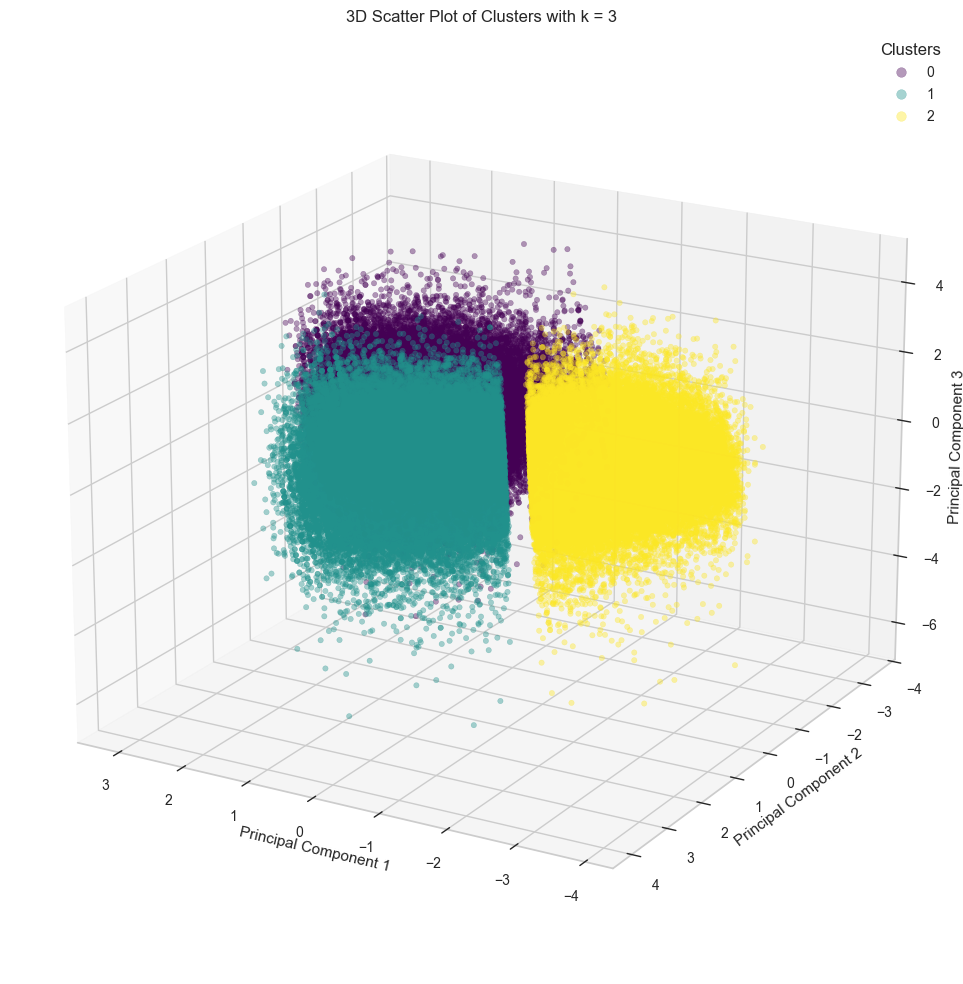

Centroids coordinates:
 [[ 1.23123823 -0.785433    0.01397668]
 [ 0.39603441  0.99668241 -0.04047043]
 [-1.79364996 -0.24350677  0.02958618]]


In [45]:

pca_3d = PCA(n_components = 3)
pca_features_3d = pca_3d.fit_transform(temp_kmeans_scaled.dropna())
kmeans_3d = KMeans(n_clusters = optimal_k, random_state = 42)
clusters_3d = kmeans_3d.fit_predict(pca_features_3d)

pca_df_3d = pd.DataFrame(data = pca_features_3d, columns = ['PC1', 'PC2', 'PC3'])
pca_df_3d['cluster'] = clusters_3d

kmeans_centroids = KMeans(n_clusters = optimal_k, random_state = 42)
kmeans_centroids.fit(pca_features_3d)
centroids = kmeans_centroids.cluster_centers_

fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection = '3d')

scatter_centroids = ax.scatter(pca_df_3d['PC1'], pca_df_3d['PC2'], pca_df_3d['PC3'], c = pca_df_3d['cluster'], cmap = 'viridis', s= 15, alpha = 0.4)

ax.set_title('3D Scatter Plot of Clusters with k = 3')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

handles, labels = scatter_centroids.legend_elements()
ax.legend(handles = handles, labels = labels, title = 'Clusters')

plt.tight_layout()
ax.view_init(elev = 20, azim = 120)
plt.show()

print("Centroids coordinates:\n", centroids)



#### Great we can clearly see the separation of our 3 clusters above.

#### Now let's take a look at the centroids themselves and derive what unerlying characteristics exist within them using some of our plots.

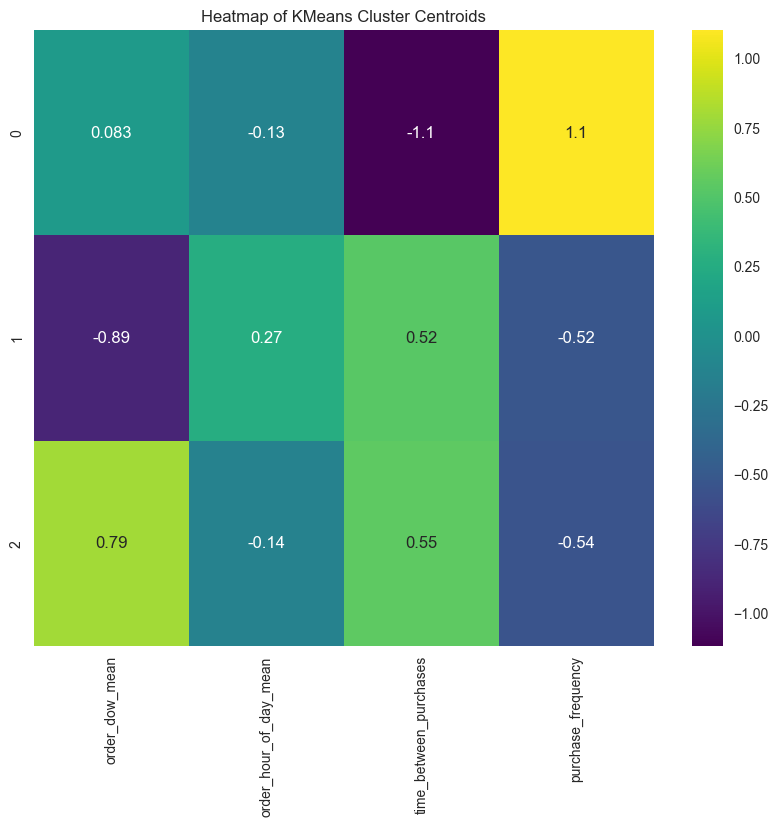

In [35]:
used_columns = ['order_dow_mean', 'order_hour_of_day_mean', 'time_between_purchases','purchase_frequency']
cluster_data = kmeans_scaled[used_columns]

kmeans = KMeans(n_clusters = optimal_k, random_state=42)
kmeans.fit(cluster_data)
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns = used_columns)

plt.figure(figsize = (10,8))
sns.heatmap(centroids_df, annot = True, cmap = 'viridis')
plt.title("Heatmap of KMeans Cluster Centroids")
plt.show()

#### Based on the above heatmap, we can see customer segmentation and characterization from our 3 clusters. Here is what can be observed:

#### Cluster 0: High purchase frequency, short time between purchases, orders slightly earlier in the day, and average on popular days.

#### Cluster 1: Lower purchase frequency, longer time between purchases, orders later in the day, and less on popular days.

#### Cluster 2: Lower purchase frequency, longer time between purchases, orders slightly earlier in the day, and on popular days.



#### The above heatmap is great for initial observations, and we will lean on this in our summary.  However when comparing our clustering methods together at the end we will need other metrics.  Let's look at some others here so that we can do such comparisons, starting with the silhouette coefficient (already completed above with our silhouette analysis) for the centroids then working through WCSS (withing-cluster sum of squares) and then BCSS (between-cluster sum of squares).

#### Referencing what the silhouette plot and score is for n_clusters = 3 for our target cluster:
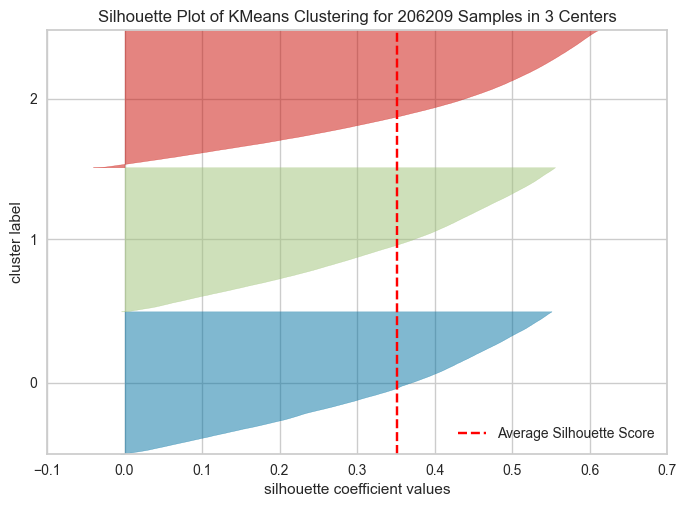

#### Silhouette score for n_clusters = 3: 0.35214482246810624

In [37]:
wcss_kmeans = kmeans.inertia_
print(f"WCSS (KMeans): {wcss_kmeans}")

WCSS (KMeans): 473425.8319495664


In [38]:
overall_mean = np.mean(cluster_data.values, axis = 0)
bcss_kmeans = sum(len(cluster_data[kmeans.labels_ == i]) * np.sum((centroid - overall_mean)** 2) for i, centroid in enumerate(kmeans.cluster_centers_))
print(f"BCSS (KMeans): {bcss_kmeans}")

BCSS (KMeans): 351379.47493402293


In [42]:
distances_kmeans = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, 'euclidean')
distances_kmeans_df = pd.DataFrame(distances_kmeans, columns = [f'Cluster {i}' for i in range(optimal_k)], index = [f'Cluster {i}' for i in range(optimal_k)])

print(f"Euclidean Distance between KMeans Centroids:")
print(distances_kmeans_df)


Euclidean Distance between KMeans Centroids:
           Cluster 0  Cluster 1  Cluster 2
Cluster 0   0.000000   2.537410   2.447796
Cluster 1   2.537410   0.000000   1.731075
Cluster 2   2.447796   1.731075   0.000000


#### Great we will use these numbers provided in our conclusion summary to compare with the other clustering methods.

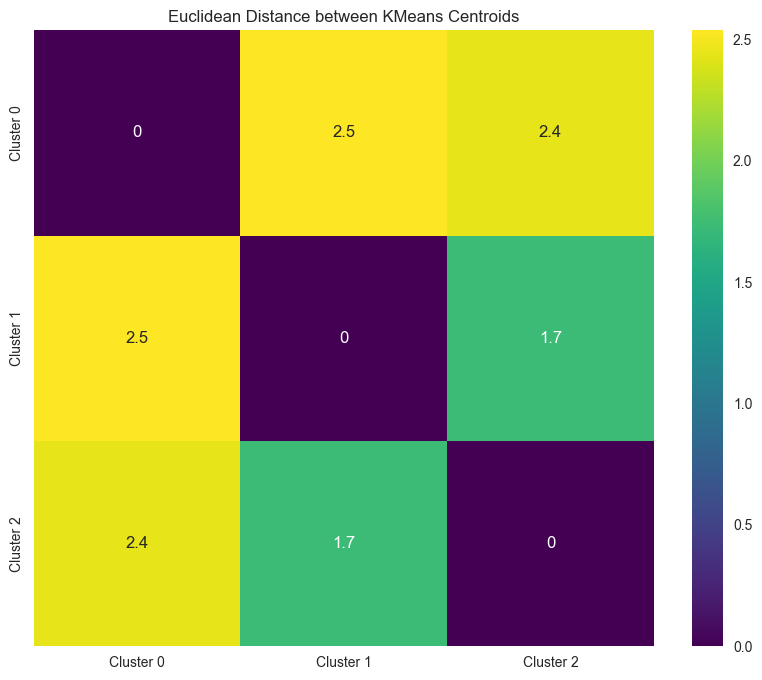

In [43]:
plt.figure(figsize=(10, 8))
sns.heatmap(distances_kmeans_df, annot = True, cmap = 'viridis')
plt.title('Euclidean Distance between KMeans Centroids')
plt.show()

#### In the above heatmap for showing Euclidean distances you can see that Cluster 0 and Cluster 1 are well-separated, as are Cluster 0 and Cluster 2.  Cluster 1 and Cluster 2 still have a decent degree of separation, however further diagnosis may need to be done.

#### Let's now get a count of how many customers are being represented in each one of these clusters (groups) using the KMeans clustering method.

kmeans_opt_cluster
1    70154
0    69330
2    66725
Name: count, dtype: int64


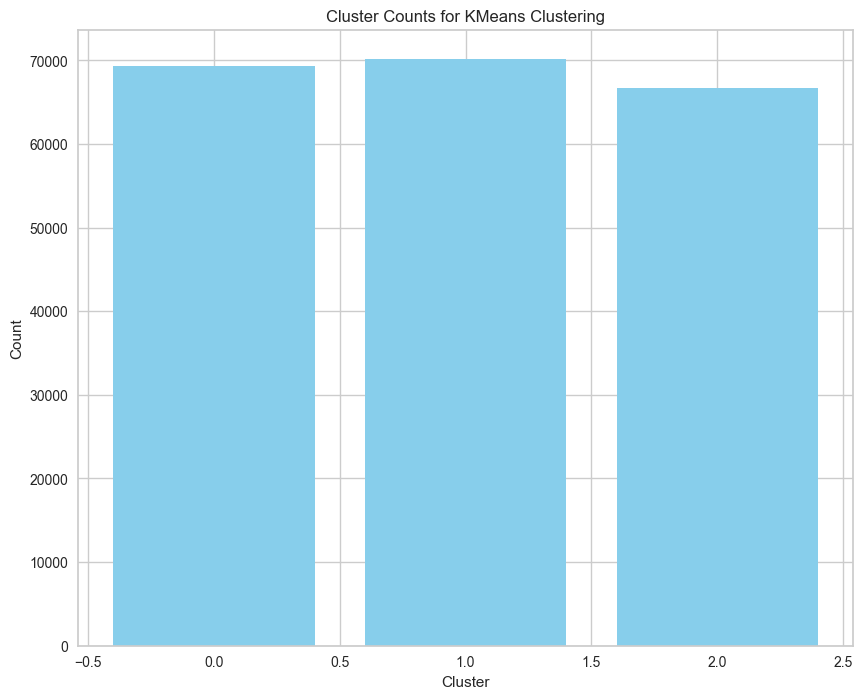

In [51]:
cluster_counts_kmeans = kmeans_scaled['kmeans_opt_cluster'].value_counts()
print(cluster_counts_kmeans)

cluster_counts_kmeans.columns = ['Cluster', 'Count']
plt.figure(figsize = (10,8))
plt.bar(cluster_counts_kmeans.index, cluster_counts_kmeans.values, color = 'skyblue')
plt.title("Cluster Counts for KMeans Clustering")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

#### Nice visual to see the population distribution for our KMeans cluster, very even which is what we are looking for here.

#### Starting to wrap up for this notebook let's plot individual pairplots from our pairplot we used before so we can use in our summary to present.

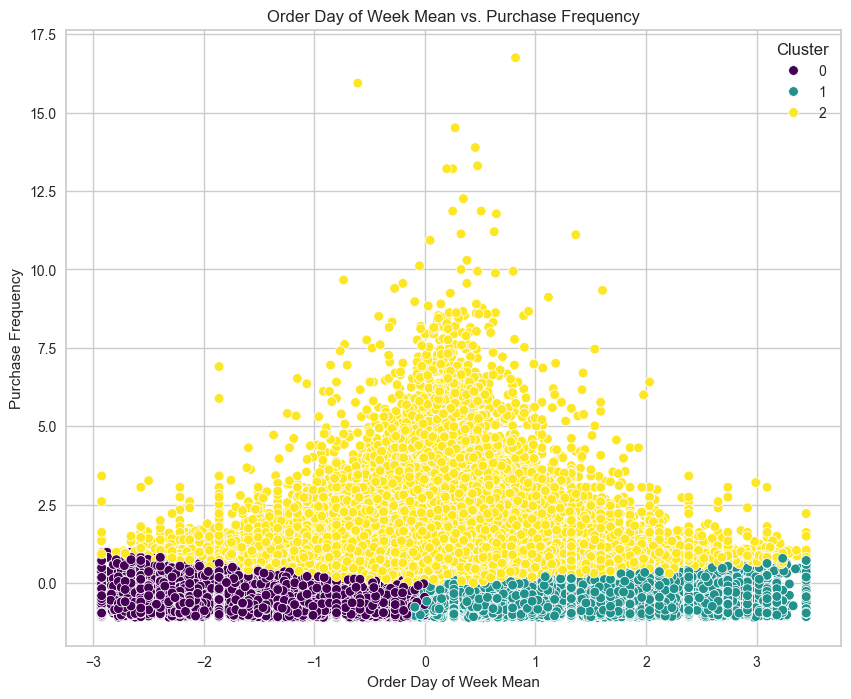

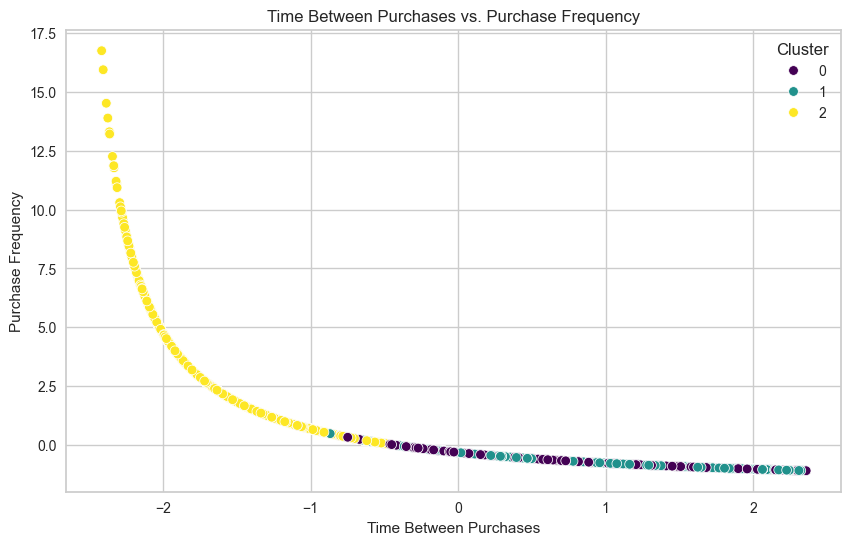

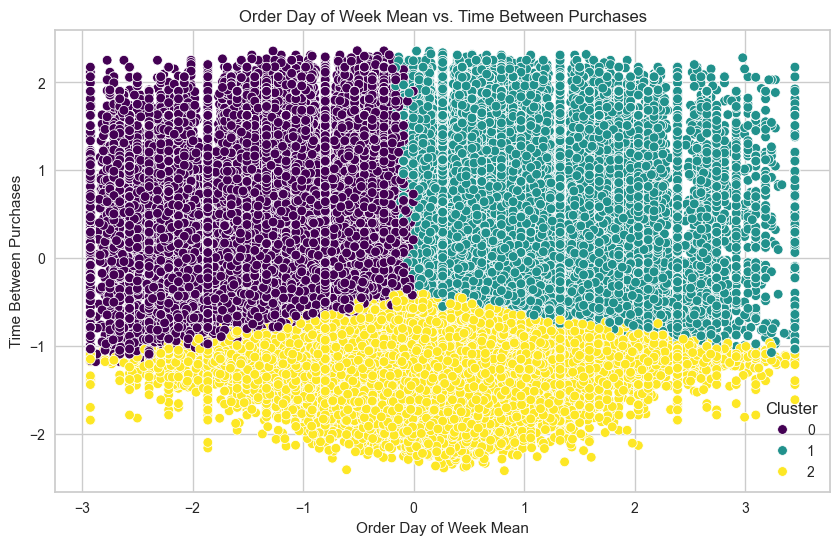

In [53]:
plt.figure(figsize = (10,8))
sns.scatterplot(data = kmeans_scaled, x = 'order_dow_mean', y = 'purchase_frequency', hue = 'kmeans_opt_cluster', palette = 'viridis')
plt.title("Order Day of Week Mean vs. Purchase Frequency")
plt.xlabel("Order Day of Week Mean")
plt.ylabel("Purchase Frequency")
plt.legend(title = "Cluster")
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=kmeans_scaled, x='time_between_purchases', y='purchase_frequency', hue='kmeans_opt_cluster', palette='viridis')
plt.title('Time Between Purchases vs. Purchase Frequency')
plt.xlabel('Time Between Purchases')
plt.ylabel('Purchase Frequency')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(data=kmeans_scaled, x='order_dow_mean', y='time_between_purchases', hue='kmeans_opt_cluster', palette='viridis')
plt.title('Order Day of Week Mean vs. Time Between Purchases')
plt.xlabel('Order Day of Week Mean')
plt.ylabel('Time Between Purchases')
plt.legend(title='Cluster')
plt.show()






#### As we have done before let's save our work so we can keep using in the next notebook(s).

In [ ]:
main_path = r'C:/Users/ryanm/Desktop/df-user-scaled.csv'

df_user_scaled.to_csv(main_path, index = False)


